In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import collections
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.decomposition import PCA
np.random.seed(42)



In [2]:
# Cases from the 9th circuit court of appeals

df=pd.read_pickle('./processed_text')

In [3]:
# Cases from appellate jurisdictions other than 9th

df2=pd.read_pickle('./dc_processed_text')

# A. Label cases based on whether from the 9th circuit's jurisdiction (0) or outside the 9th circuit (1)

In [4]:
df['label']=0

In [5]:
df2['label']=1

In [6]:
df.shape

(247, 42)

In [7]:
df2.shape

(205, 42)

In [8]:
combined=pd.concat([df, df2])

In [9]:
combined['label'].value_counts()

0    247
1    205
Name: label, dtype: int64

In [10]:
# To avoid give-aways about which circuit we're in, from the heading of the case, 
# trim the first 500 words away from each case

combined['text3']=combined['text2'].map(lambda x: x[500:])

In [11]:
# To avoid give-aways about which circuit we're in, from the heading of the case, 
# trim the first 500 words away from each case

combined['text3']=combined['text3'].map(lambda x: x[:-500])

In [12]:
train, test = train_test_split(combined, stratify=combined['label'], random_state=42)

In [13]:
train['label'].value_counts()

0    185
1    154
Name: label, dtype: int64

In [14]:
test['label'].value_counts()

0    62
1    51
Name: label, dtype: int64

# B. Generate Feature Embeddings for Each Case Using Doc2Vec

In [15]:
def make_tagged_document(row):
    return TaggedDocument(words=row['text2'],
                          tags=[row['label']])
    

In [16]:
tagged_train_data=train.apply(lambda row: make_tagged_document(row), axis=1)

In [17]:
tagged_test_data=test.apply(lambda row: make_tagged_document(row), axis=1)

In [18]:
model = Doc2Vec(vector_size=100,  
                min_count=20,
                epochs=40)

In [19]:
model.build_vocab(tagged_train_data)

In [20]:
model.train(tagged_train_data,
           total_examples=model.corpus_count,
           epochs=model.epochs)

In [21]:
model.docvecs.count

2

In [22]:
# Infer Vector Methods Adapted from https://fzr72725.github.io/2018/01/14/genism-guide.html

In [23]:
y_train=np.array([doc.tags[0] for doc in tagged_train_data])

In [24]:
y_test=np.array([doc.tags[0] for doc in tagged_test_data])

In [25]:
X_train=[model.infer_vector(doc.words, steps=20) for doc in tagged_train_data]

In [26]:
X_test=[model.infer_vector(doc.words, steps=20) for doc in tagged_test_data]

In [27]:
X_train=np.vstack(X_train)

In [28]:
X_test=np.vstack(X_test)

In [29]:
X_test.shape

(113, 100)

In [30]:
y_test.shape

(113,)

In [31]:
X_train.shape

(339, 100)

In [32]:
y_train.shape

(339,)

In [33]:
# 99.11% of the time, an inferred document vector is most similar
# to the matching document vector in the Doc2Vec model 

correct=0

for index in range(X_train.shape[0]):
    similar=model.docvecs.most_similar([X_train[index]])[0][0]
    if similar == y_train[index]:
        correct += 1

print (correct/X_train.shape[0])

0.9911504424778761


# C. Logistic Model to Sort Out Both Categories of Cases

In [34]:
pipeline1 = Pipeline([
    
    ('ss', StandardScaler()),
    ('lm', LogisticRegression())
])

In [35]:
hyperparameters={
                'lm__C': [0.00001, 0.0001, 0.001],
                'lm__penalty': ['l1', 'l2']
}

In [36]:
                
lingrid = GridSearchCV(pipeline1, hyperparameters, cv=3)

In [37]:
_=lingrid.fit(X_train, y_train)

In [38]:
lingrid.best_params_

{'lm__C': 0.001, 'lm__penalty': 'l2'}

In [39]:
lingrid.score(X_train, y_train)

0.9852507374631269

In [40]:
lingrid.score(X_test, y_test)

0.911504424778761

In [41]:
roc_auc_score(y_test, lingrid.predict(X_test))

0.9176154332700823

In [42]:
roc_auc_score(y_train, lingrid.predict(X_train))

0.9853983853983852

In [43]:
confusion_matrix(y_test, lingrid.predict(X_test))

array([[53,  9],
       [ 1, 50]])

# D. Support Vector Machine

In [44]:
pipeline3 = Pipeline([
    
    ('ss', StandardScaler()),
    ('sv', svm.SVC())
])



In [45]:
hyperparameters={
            'sv__C':np.logspace(-4, 2, 3) ,   
            'sv__gamma': np.logspace(-8, 2, 8)
}
                
svcgrid = GridSearchCV(pipeline3, hyperparameters, cv=3)

In [46]:
svcgrid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sv', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sv__C': array([1.e-04, 1.e-01, 1.e+02]), 'sv__gamma': array([1.00000e-08, 2.68270e-07, 7.19686e-06, 1.93070e-04, 5.17947e-03,
       1.38950e-01, 3.72759e+00, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
svcgrid.best_params_

{'sv__C': 100.0, 'sv__gamma': 7.196856730011529e-06}

In [48]:
svcgrid.score(X_train, y_train)

0.9941002949852508

In [49]:
svcgrid.score(X_test, y_test)

0.9026548672566371

In [50]:
roc_auc_score(y_test, svcgrid.predict(X_test))

0.9043327008222642

In [51]:
roc_auc_score(y_train, svcgrid.predict(X_train))

0.9935064935064934

# E.  PCA reduction to 2 dimensions

In [52]:
# Method adapted from https://github.com/sdimi/average-word2vec/blob/master/avg_word2vec_from_documents.py

In [53]:
ss=StandardScaler()
pca=PCA(n_components=2)

In [54]:
X_train_std=ss.fit_transform(X_train)
X_test_std=ss.fit_transform(X_test)

In [55]:
X_train_std_flat=pca.fit_transform(X_train_std)
X_test_std_flat=pca.fit_transform(X_test_std)

In [56]:
X_train_std_flat.shape

(339, 2)

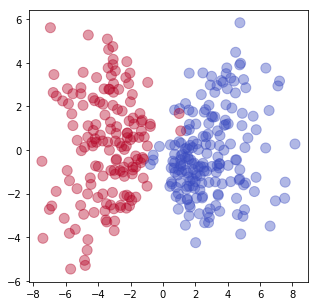

In [63]:
plt.figure(1, figsize=(5, 5))
plt.scatter(X_train_std_flat[:, 0], X_train_std_flat[:, 1],s=100, c=y_train, alpha=0.4, cmap="coolwarm")
plt.savefig('./training_set')

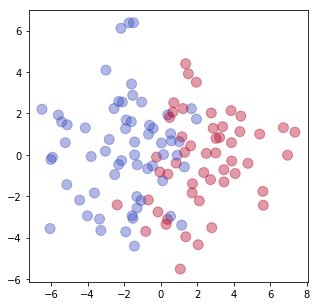

In [64]:
plt.figure(1, figsize=(5, 5))
plt.scatter(X_test_std_flat[:, 0], X_test_std_flat[:, 1],s=100, c=y_test, alpha=.4, cmap="coolwarm")
plt.savefig('./test_set')